In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin
import numpy as np
from scipy.stats import t

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

Hello!

This is a little project on data visualization, hypothesis testing, predicting with ML model and making some conclusions out of the results we get.

The dataset I'm working with is "Student Performance Factors" that I found on Kaggle. Thanks to the author for it!
URL: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors

Firstly, let's import it and have a look

In [2]:
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

stud_exams = pd.read_csv(path +'\StudentPerformanceFactors.csv')
stud_exams.head()

100%|██████████| 93.9k/93.9k [00:00<00:00, 413kB/s]

Extracting files...


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:
stud_exams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

As we can see, there are many different columns and many of those may influence the result of the exam. 

Moreover, there are some missing data and although it's not always a good practice to just delete data, it's more than fine to do now as the size of the dataset would be still big enough

In [4]:
stud_exams.dropna(inplace=True)

print("Size of cleaned from missing values dataset- " + str(len(stud_exams)))

Size of cleaned from missing values dataset- 6378


One of a good ways to examine our data is to look at the correlations between characteristics

<Axes: >

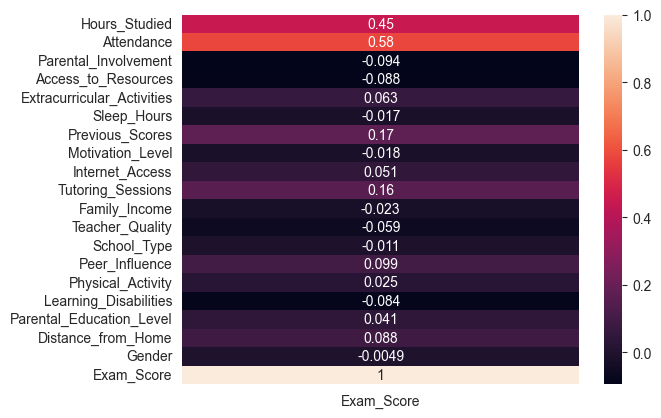

In [5]:
# Encoding our categorical variables, thus we can include them in our correlations matrix
label_encoder = LabelEncoder()
stud_exams_encoded = stud_exams.copy()

for column in stud_exams.select_dtypes(include=['object']).columns:
    stud_exams_encoded[column] = label_encoder.fit_transform(stud_exams[column])

correlation_matrix = stud_exams_encoded.corr()
exam_score_corr = correlation_matrix['Exam_Score']

sns.heatmap(exam_score_corr.to_frame(), annot=True)

In [6]:
top_5_features = exam_score_corr.drop('Exam_Score').sort_values(ascending=False).head(5)

top_5_features

Attendance           0.580259
Hours_Studied        0.445104
Previous_Scores      0.174283
Tutoring_Sessions    0.156829
Peer_Influence       0.099133
Name: Exam_Score, dtype: float64

This shows us that the most correlated factors with exam score in this dataset are attendance, hours studied and previous scores. Actually it makes sense, as usually the more you spend time on studying, the higher results you potentially can get on an exam

Now let's look at distribution of exam results

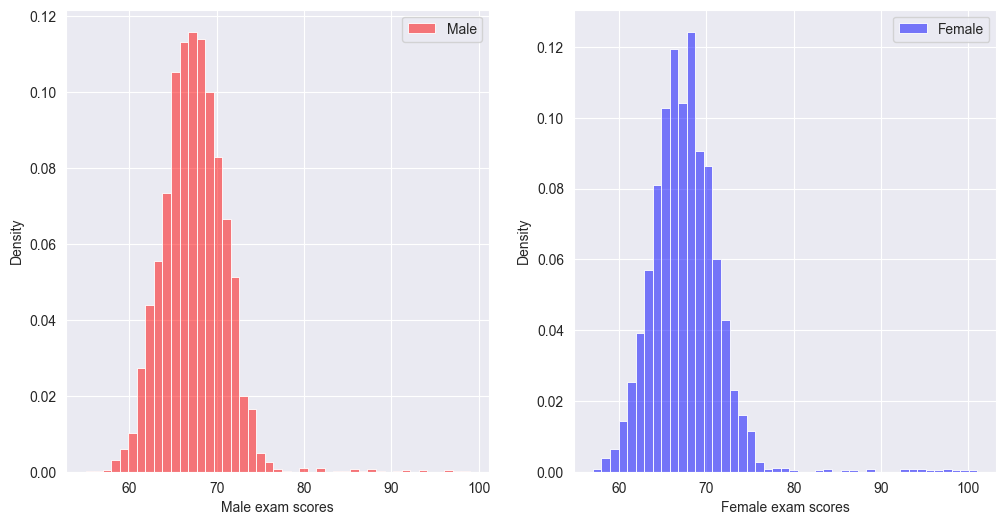

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("darkgrid")

sns.histplot(stud_exams[stud_exams['Gender']=='Male']['Exam_Score'], bins=45, kde=False, color='red', alpha=0.5, stat="density", label='Male', ax=ax[0])
ax[0].set_xlabel('Male exam scores')
ax[0].legend()

sns.histplot(stud_exams[stud_exams['Gender']=='Female']['Exam_Score'], bins=45, kde=False, color='blue', alpha=0.5, stat="density",label='Female', ax=ax[1])
ax[1].set_xlabel('Female exam scores')
ax[1].legend()

This histogram definetely looks just as normal distribution, but we can see a long right tail with scores that are above 74-75, let's look at it

Mean results that above 76 for:
Female - 88.28
Male - 86.39


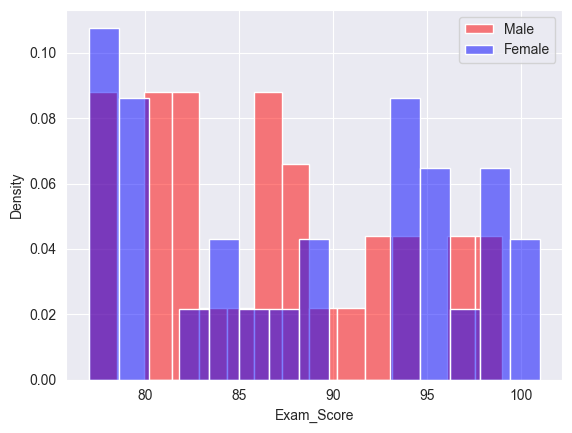

In [8]:
sns.histplot(stud_exams[(stud_exams['Gender']=='Male') & (stud_exams['Exam_Score'] > 76)]['Exam_Score'], bins=15, kde=False, color='red', alpha=0.5, stat="density", label='Male')

sns.histplot(stud_exams[(stud_exams['Gender']=='Female') & (stud_exams['Exam_Score'] > 76)]['Exam_Score'], bins=15, kde=False, color='blue', alpha=0.5, stat="density",label='Female')

plt.legend()

male_mean_best_res = stud_exams[(stud_exams['Gender']=='Male') & (stud_exams['Exam_Score'] > 76)]['Exam_Score'].mean()
female_mean_best_res = stud_exams[(stud_exams['Gender']=='Female') & (stud_exams['Exam_Score'] > 76)]['Exam_Score'].mean()

print("Mean results that above 76 for:")
print("Female - " + str(round(female_mean_best_res, 2)))
print("Male - " + str(round(male_mean_best_res, 2)))

Although there are no clear differences between genders in term of studying and passing tests, it seems that girls did a little better this time (those who got more than 76)

Considering we have a column of previous exam scores, it's interesting to examine how the mean result overall changed

In [9]:
mean_exam_sc = stud_exams['Exam_Score'].mean()
mean_pr_exam_sc = stud_exams['Previous_Scores'].mean()

mean_diff = mean_exam_sc - mean_pr_exam_sc
print("Exam results- " + str(round(mean_exam_sc, 1)))
print("Previous exam results- " + str(round(mean_pr_exam_sc, 1)))
print("Difference between mean results of previous and this exam- " + str(round(mean_diff, 1)))

Exam results- 67.3
Previous exam results- 75.1
Difference between mean results of previous and this exam- -7.8


Apparently, students did much worse this time, maybe these exams were more challenging

Despite the results of this exam are worse, maybe students that got bad results last time decided to study harder

<Axes: xlabel='Exam_Score', ylabel='Previous_Scores'>

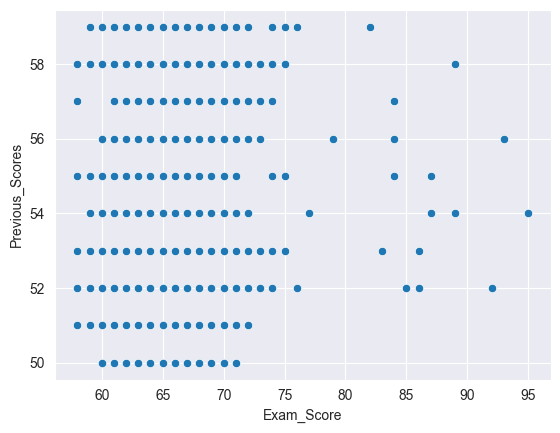

In [10]:
sns.scatterplot(stud_exams[stud_exams['Previous_Scores'] < 60], y='Previous_Scores', x='Exam_Score')

In [11]:
mean_e = stud_exams[stud_exams['Previous_Scores']<60]['Exam_Score'].mean()

print("Mean results for students who got less than 60 on previous exam- " + str(round(mean_e, 1)))

Mean results for students who got less than 60 on previous exam- 66.4


Next factor which is worth examining is distance from home, as it makes sense as students that live far away need to spend more time just to get to their university, therefore there is less time for other activities and, of course, studying

C:\Users\Владислав\AppData\Local\Temp\ipykernel_28192\1138751027.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Distance_from_Home', y='Exam_Score', data=mean_sc_by_dist_df, palette=sns.color_palette("husl", len(mean_sc_by_dist_df)))
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of 

(65.49842767295597, 68.51381215469613)

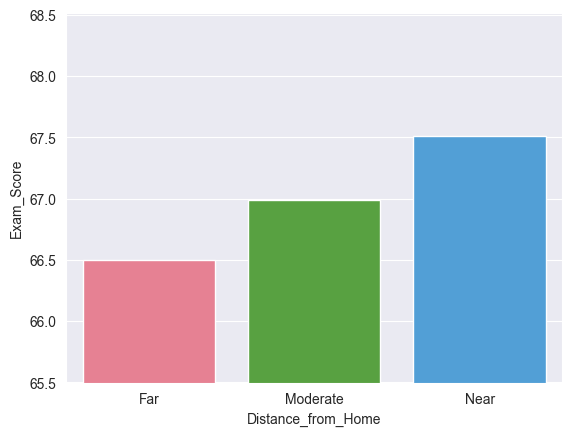

In [12]:
mean_sc_by_dist = stud_exams.groupby('Distance_from_Home')['Exam_Score'].mean()
mean_sc_by_dist_df = mean_sc_by_dist.reset_index()

sns.barplot(x='Distance_from_Home', y='Exam_Score', data=mean_sc_by_dist_df, palette=sns.color_palette("husl", len(mean_sc_by_dist_df)))
plt.ylim(mean_sc_by_dist_df['Exam_Score'].min() - 1, mean_sc_by_dist_df['Exam_Score'].max() + 1)

Although the difference is small, but still students that live near on average get one point more than those who are far away

As we remember, our two most correlated feature was attendance and studied hours, let's look how it affects exam score

Text(0.5, 1.0, 'How attendance affect exam score')

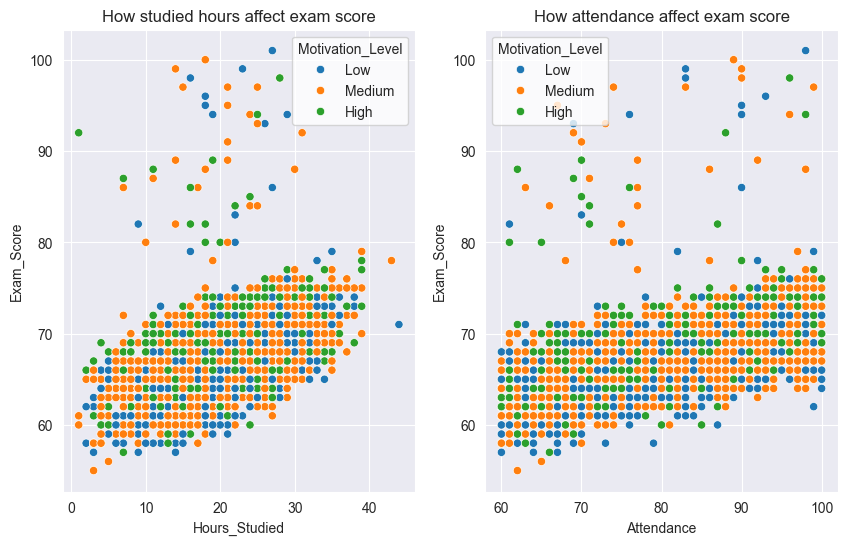

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.set_style("white")

sns.scatterplot(stud_exams, y='Exam_Score', x='Hours_Studied', hue='Motivation_Level', ax=ax[0])
ax[0].set_title('How studied hours affect exam score')

sns.scatterplot(stud_exams, y='Exam_Score', x='Attendance', hue='Motivation_Level', ax=ax[1])
ax[1].set_title('How attendance affect exam score')

Apparently, we can't see correlation between hours studied/attendance and motivation level

Does teacher quality influence exam results? 

C:\Users\Владислав\AppData\Local\Temp\ipykernel_28192\1394986668.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.barplot(sc_teac_qual, x='Teacher_Quality', y='Exam_Score', hue='Motivation_Level', color='green')
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_g

(65.01973684210526, 69.29145728643216)

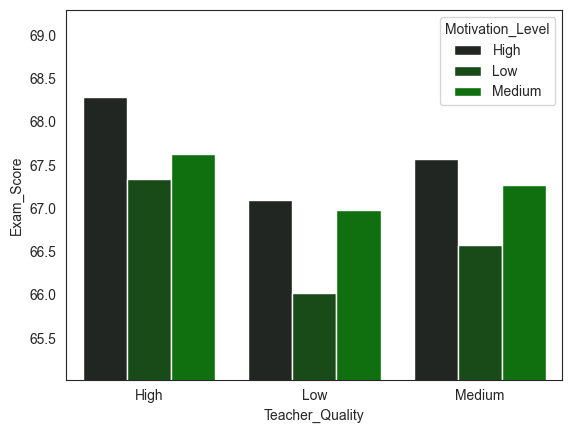

In [14]:
sc_teac_qual = stud_exams.groupby(['Teacher_Quality', 'Motivation_Level'])['Exam_Score'].mean().reset_index()
sns.barplot(sc_teac_qual, x='Teacher_Quality', y='Exam_Score', hue='Motivation_Level', color='green')

plt.ylim(sc_teac_qual['Exam_Score'].min() - 1, sc_teac_qual['Exam_Score'].max() + 1)

And again, difference is not that big, but still it exists and now we clearly see that motivation level also affects exam results

C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

<Axes: xlabel='Parental_Involvement', ylabel='Exam_Score'>

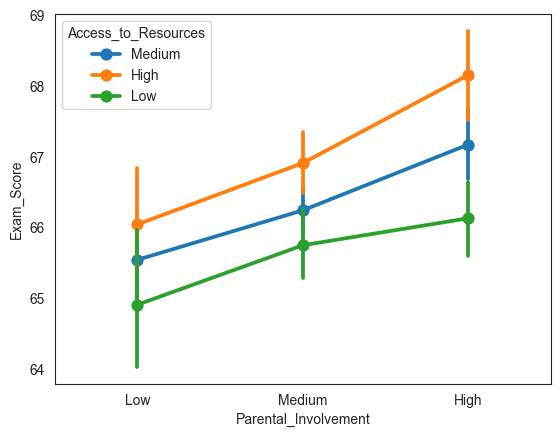

In [15]:
sns.pointplot(stud_exams[stud_exams['Previous_Scores'] < 65], x='Parental_Involvement', y='Exam_Score', hue='Access_to_Resources')

This point plot shows that parental involvement and access to resources positively affects exam results  

As you probably noticed earlier, we have a column that gives us information whether a student has learning disabilities. This also may influence exam results, this time negatively (if a student has disabilities)

C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='Learning_Disabilities', ylabel='Exam_Score'>

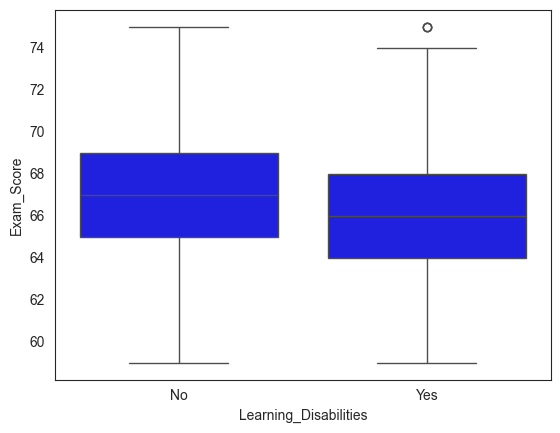

In [16]:
Q1 = stud_exams['Exam_Score'].quantile(0.25)
Q3 = stud_exams['Exam_Score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stud_exams_filt = stud_exams[(stud_exams['Exam_Score'] >= lower_bound) & (stud_exams['Exam_Score'] <= upper_bound)]

sns.boxplot(stud_exams_filt, x='Learning_Disabilities', y='Exam_Score', color='blue')

Students with learning disabilities have lower grades and it might be a problem, because every student must have equal possibilities. Maybe teachers should pay more attention to students with disabilities and help them in studying process


Earlier we saw that difference between last and this exam sessions is almost 8 points. Is this statistically significant difference? With t-test we can check it

Our null hypothesis is that exam scores are not less in average than previous scores
Our alternative hypothesis is that exam scores are lower in average than previous scores

In [17]:
pingouin.ttest(x=stud_exams["Exam_Score"], y=stud_exams["Previous_Scores"], paired=True, alternative='less', confidence=0.99)

print("P value is around 0, which means that we reject our null hypothesis")

P value is around 0, which means that we reject our null hypothesis


Well, results of this test were quite expected, so let's conduct another test.
Let's check whether there are statistically significant difference between exam results of 2 genders

Null hypothesis - there is no difference between exam results of 2 genders
Alternative hypothesis - there is difference between exam results of 2 genders

This time we should alst use t-test

In [18]:
significance_level = 0.01

male_avg = stud_exams[stud_exams['Gender'] == 'Male']['Exam_Score'].mean()
female_avg = stud_exams[stud_exams['Gender'] == 'Female']['Exam_Score'].mean()

sample_diff = abs(male_avg - female_avg)
popul_diff = 0 # our H0 is that there is no difference between genders' exam results

m_size = len(stud_exams[stud_exams['Gender'] == 'Male'])
f_size = len(stud_exams[stud_exams['Gender'] == 'Female'])

m_std = stud_exams[stud_exams['Gender'] == 'Male']['Exam_Score'].std()
f_std = stud_exams[stud_exams['Gender'] == 'Female']['Exam_Score'].std()

st_error = np.sqrt(m_std ** 2 / m_size + f_std ** 2 / f_size)

t_stat = (sample_diff - popul_diff) / st_error

degrees_of_freedom = m_size + f_size - 2
p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)

print(str(round(p_value, 2)) + " - P value is greater than our significance level, thus we fail to reject null hypothesis")

0.35 - P value is greater than our significance level, thus we fail to reject null hypothesis


After we did all this work, let's try to create a predictor of student's exam score based on characteristics we know
Let's try to use Random Forest Regressor model in scikit-learn

We don't have so much data, thus it is a good practice to use GridSearchCV for choosing the best parameters for our model as it will not take long


In [19]:
X = stud_exams_encoded.drop('Exam_Score', axis=1)
y = stud_exams['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [150, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [3, 4, 6],
    'bootstrap': [False, True]
}

In [20]:
r_forest_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=r_forest_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-pack

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [3, 4, 6],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 300]},
             scoring='neg_mean_squared_error')

In [21]:
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

In [22]:
# Results of gridsearch are this params

params = {'bootstrap': [True],
 'max_depth': [None],
 'min_samples_leaf': [4],
 'min_samples_split': [2],
 'n_estimators': [150]}

In [24]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


# Converting negative MSE to positive RMSE

cv_rmse = np.sqrt(-cv_scores)


y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Random Forest model results (on test dataset):")
print("Root mean squared error - ", round(cv_rmse.mean(), 2))

print("Root mean squared error standart deviation- ", round(cv_rmse.std(), 2))

print("Mean absolute error - " , round(mae, 2))

print("R2 score - " , round(r2, 3))

Random Forest model results (on test dataset):
Root mean squared error -  2.38
Root mean squared error standart deviation-  0.24
Mean absolute error -  1.13
R2 score -  0.645


In [25]:
y_pred_tr = best_model.predict(X_train)


mse_tr = mean_squared_error(y_train, y_pred_tr)

mae_tr = mean_absolute_error(y_train, y_pred_tr)

r2_tr = r2_score(y_train, y_pred_tr)

print("Random Forest model results (on train dataset):")
print("Mean squared error - ", round(mse_tr, 2))

print("Mean absolute error - ", round(mae_tr, 2))

print("R2 score - " , round(r2_tr, 3))

Random Forest model results (on train dataset):
Mean squared error -  2.5
Mean absolute error -  0.66
R2 score -  0.836


As we can see, our model shows relatively not bad results, but clearly we can see overfitting as predictions on train dataset show much better results

In [26]:
xgb_grid = {

    'n_estimators': [75, 100, 125],

    'max_depth': [1, 2, 5],

    'min_samples_split': [0, 1, 10],

    'min_samples_leaf': [0, 1, 10],

    'bootstrap': [False]

}


xgb_model = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_grid, 

                           cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

C:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [2],
                         'min_samples_leaf': [0], 'min_samples_split': [0],
                         'n_estimators': [100]},
             scoring='neg_mean_squared_error')

In [27]:
xgb_best_params = grid_search.best_params_
xgb_model = grid_search.best_estimator_

# Results of gridsearch are this params
xgb_params = {'bootstrap': False,
 'max_depth': 2,
 'min_samples_leaf': 0,
 'min_samples_split': 0,
 'n_estimators': 100}

In [31]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost model results (on test dataset):")
print("Mean squared error - " , round(mse, 2))
print("Mean absolute error - " , round(mae, 2))
print("R2 score - " , round(r2, 3))

XGBoost model results (on test dataset):
Mean squared error -  4.44
Mean absolute error -  0.68
R2 score -  0.714


In [33]:
y_pred_tr = xgb_model.predict(X_train)

mse_tr = mean_squared_error(y_train, y_pred_tr)
mae_tr = mean_absolute_error(y_train, y_pred_tr)
r2_tr = r2_score(y_train, y_pred_tr)

print("XGBoost model results (on train dataset):")
print("Mean squared error - ", round(mse_tr, 2))
print("Mean absolute error - " , round(mae_tr, 2))
print("R2 score - " , round(r2_tr, 3))

XGBoost model results (on train dataset):
Mean squared error -  3.95
Mean absolute error -  0.65
R2 score -  0.741


XGBoost model shows most stable and better results (less difference between train and test datasets), but still a little overfitting

What can we do to improve overall performance: 
1) Obviously, add more data as our dataset is relatively small
2) Try other ML models and test more parameters 
3) If results are still poor, we can try deep learning
4) To prevent overfitting, we can remove some of the features, which aren't correlated to exam score